In [1]:
from constants import ERA5_BEST_INFERENCE_WANDB_RUN_IDS
from utils import wandb_to_beaker_result
import xarray as xr
import matplotlib.pyplot as plt
xr.set_options(keep_attrs=True)
plt.rcParams['figure.dpi'] = 300

In [2]:
wandb_id = ERA5_BEST_INFERENCE_WANDB_RUN_IDS["10yr"]
beaker_dataset_id = wandb_to_beaker_result("ace2", wandb_id)
variables = ['eastward_wind_0']

In [3]:
beaker_dataset_id

'01J4SM3X285VCJVSKW5YDWTQ4P'

In [10]:
%%bash -s "$beaker_dataset_id"
beaker dataset fetch --prefix autoregressive_ $1

Complete:        0 files, 0 B        In Progress:        1 files, 7.052 GiB 
Complete:        0 files, 0 B        In Progress:        2 files, 14.1 GiB  
Complete:        1 files, 7.052 GiB  In Progress:        1 files, 7.052 GiB 
Complete:        2 files, 14.1 GiB   In Progress:        0 files, 0 B       
Completed in 3m34.6s: 67.27 MiB/s, 0 files/s



You are running Beaker CLI version v1.5.54, but there's a newer version available: v1.5.152.

Consider upgrading today! See https://beaker-docs.apps.allenai.org/start/install.html#install


In [4]:
#ds_pred = beaker_to_xarray(beaker_dataset_id, "autoregressive_predictions.nc")
ds_pred = xr.open_dataset('autoregressive_predictions.nc').isel(sample=0)
ds_pred = ds_pred[variables]
ds_pred['time'] = ds_pred['valid_time']
#ds_pred = ds_pred.set_xindex('time')

#ds_target = beaker_to_xarray(beaker_dataset_id, "autoregressive_target.nc")
ds_target = xr.open_dataset('autoregressive_target.nc').isel(sample=0)
ds_target = ds_target[variables]
ds_target['time'] = ds_target['valid_time']
#ds_target = ds_target.set_xindex('time')

In [7]:
ds = xr.concat(
    [
        ds_target.assign_coords(source="target"),
        ds_pred.assign_coords(source="pred")
    ],
    dim="source"
)

In [8]:
ds_zm = ds.mean('lon')

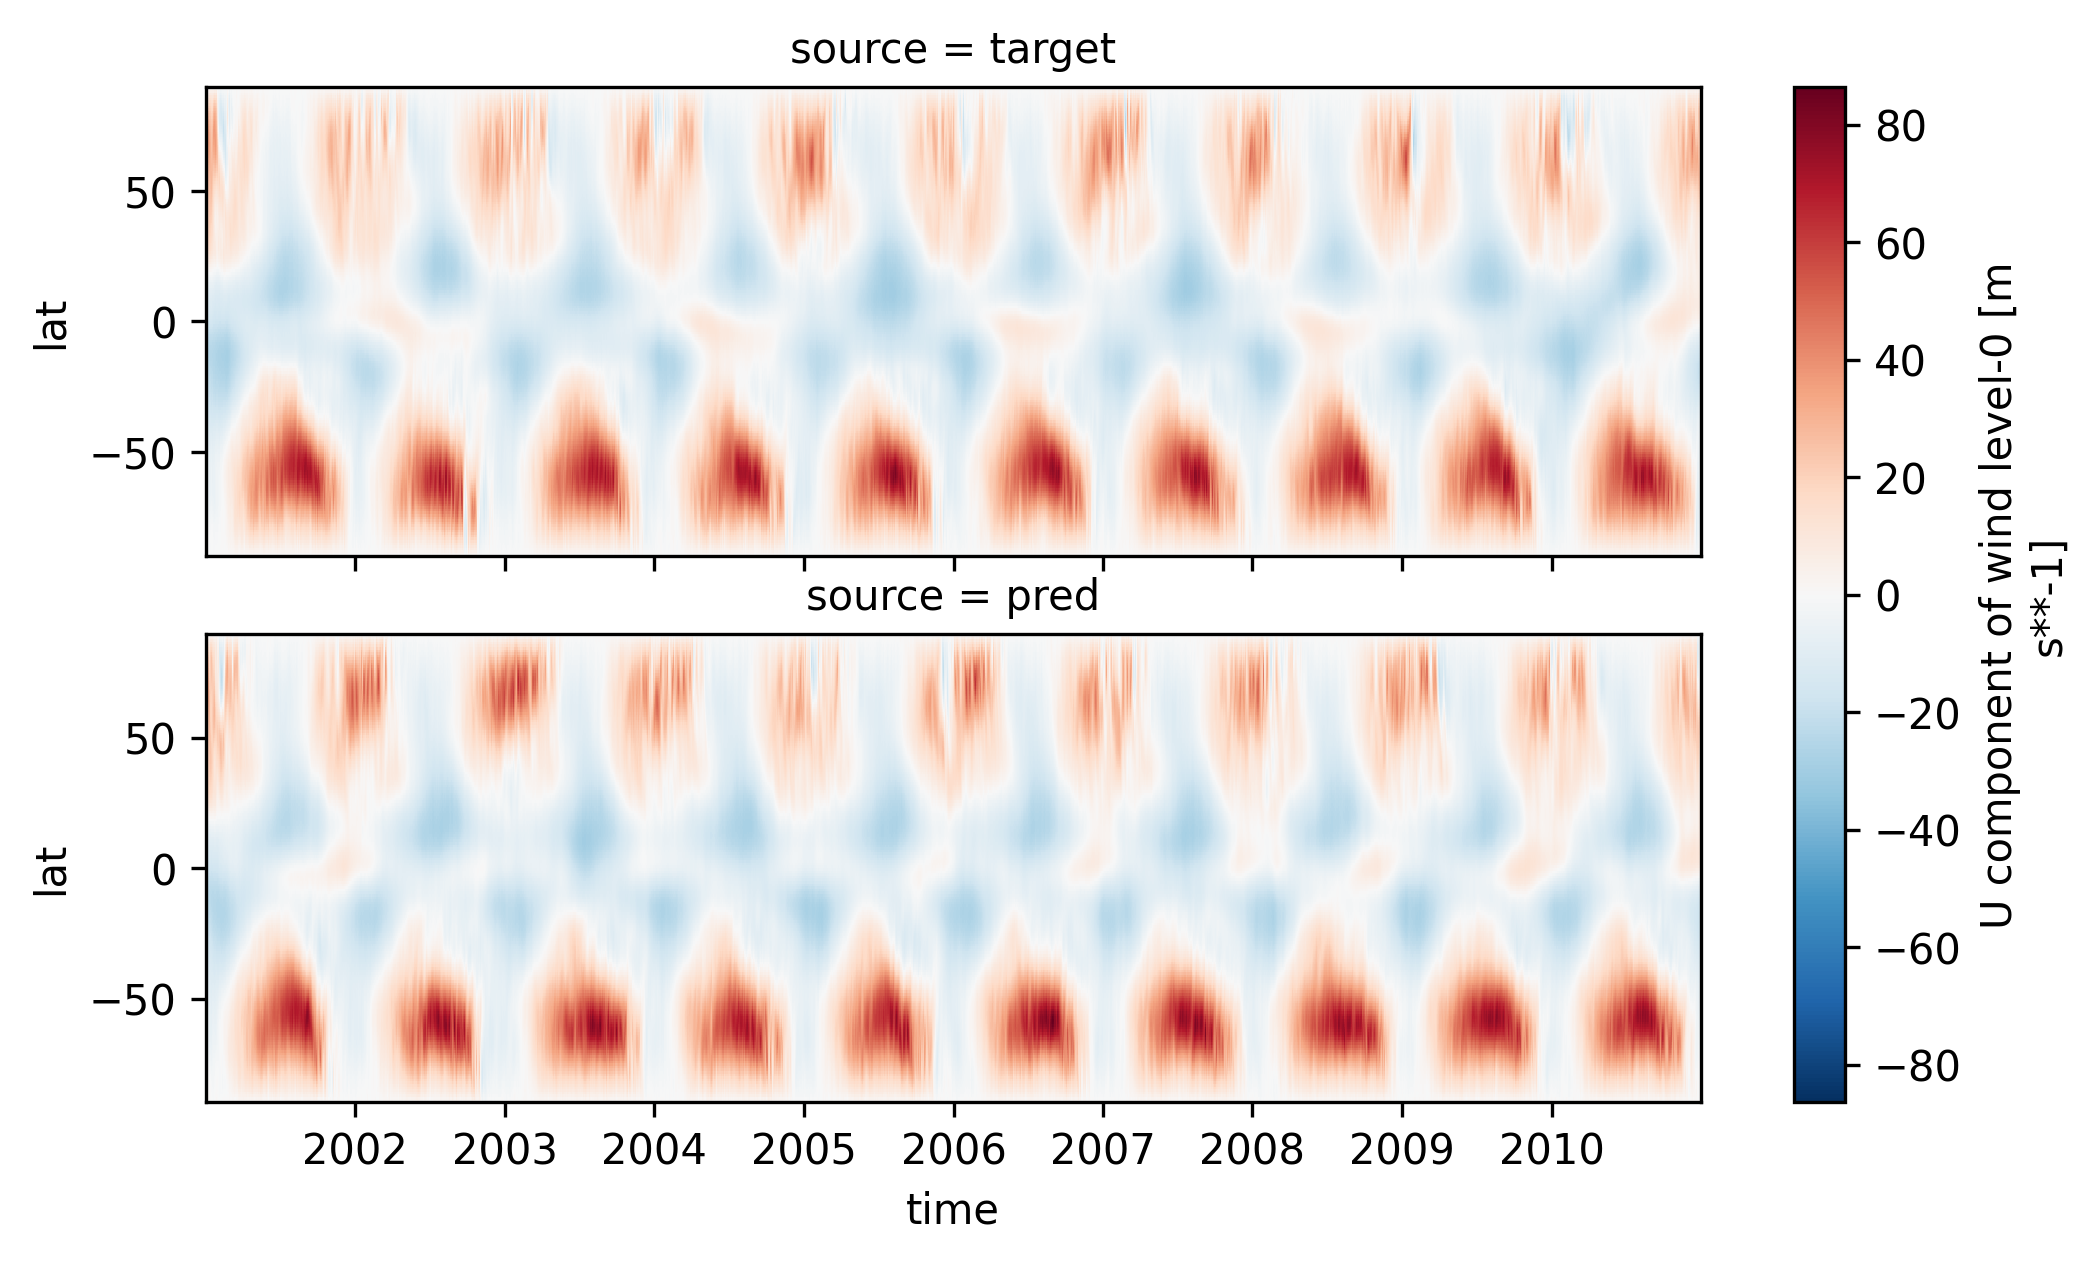

In [11]:
fg = ds_zm.eastward_wind_0.plot(x='time', row='source')
fg.fig.set_size_inches((8, 4))

In [28]:
def compute_and_plot_annual_cycle(ax, da, roll=None):
    clim = da.groupby('time.dayofyear').mean('time')
    clim = clim.isel(dayofyear=slice(0, 365))  # drop leap day
    if roll is not None:
        clim = clim.roll(dayofyear=-roll, roll_coords=True)
        increasing_dayofyear = clim.dayofyear.values
        increasing_dayofyear[-roll:] += 365
        clim['dayofyear'] = increasing_dayofyear
        clim['dayofyear'].attrs['long_name'] = f'Day of year (shifted by {roll})'
    start_year = da.time.dt.year.min().values.item()
    end_year = da.time.dt.year.max().values.item()
    clim.plot(ax=ax, color='k', linestyle='-', label='Climatology')
    for year in range(start_year, end_year + 1):
        current_year = da.sel(time=str(year)).groupby('time.dayofyear').mean('time')
        if roll is not None:
            current_year = current_year.roll(dayofyear=-roll, roll_coords=True)
            increasing_dayofyear = current_year.dayofyear.values
            increasing_dayofyear[-roll:] += 365
            current_year['dayofyear'] = increasing_dayofyear
            current_year['dayofyear'].attrs['long_name'] = f'Day of year (shifted by {roll})'
        current_year.plot(ax=ax, color='gray', alpha=0.5, linewidth=0.8)
    ax.legend()

In [35]:
def plot_combined_annual_cycle(da, lat, roll=None, ylim=None):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    lat_name = f'{lat}N' if lat > 0 else f'{-lat}S'
    start_year = da.time.dt.year.min().values.item()
    end_year = da.time.dt.year.max().values.item()
    for i, source in enumerate(['target', 'pred']):
        da = ds_zm.eastward_wind_0.sel(source=source).sel(lat=lat, method='nearest')
        compute_and_plot_annual_cycle(axes[i], da, roll=roll)
        axes[i].set_title(source)
        if ylim is not None:
            axes[i].set_ylim(ylim)
    fig.suptitle(f'Zonal mean eastward_wind_0 at {lat_name} ({start_year}-{end_year})')
    fig.tight_layout()

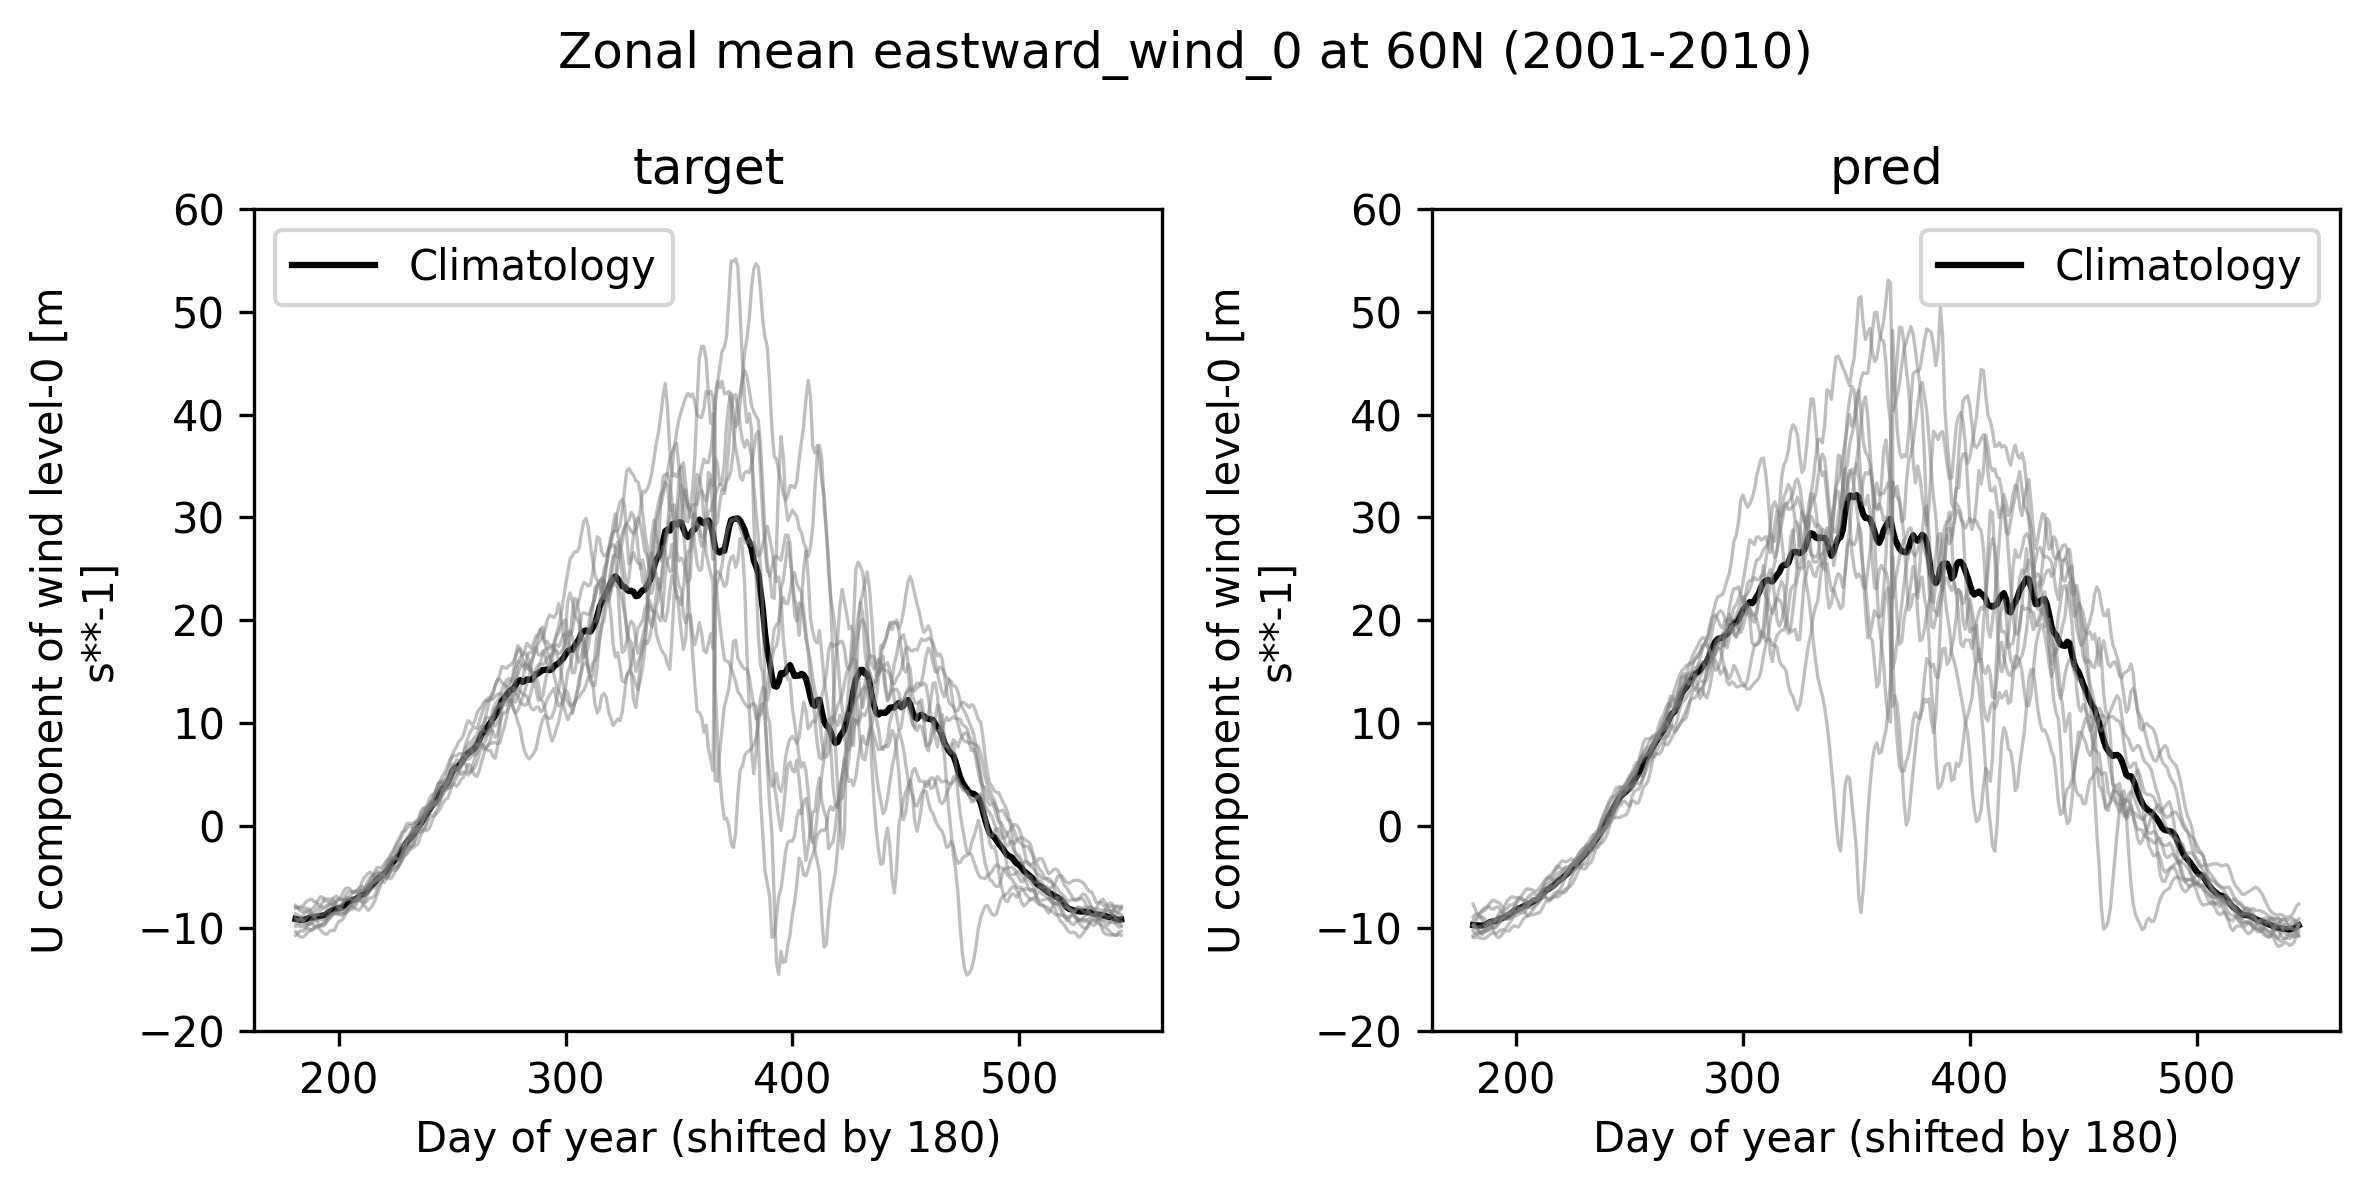

In [36]:
plot_combined_annual_cycle(ds_zm.eastward_wind_0, 60, roll=180, ylim=[-20, 60])

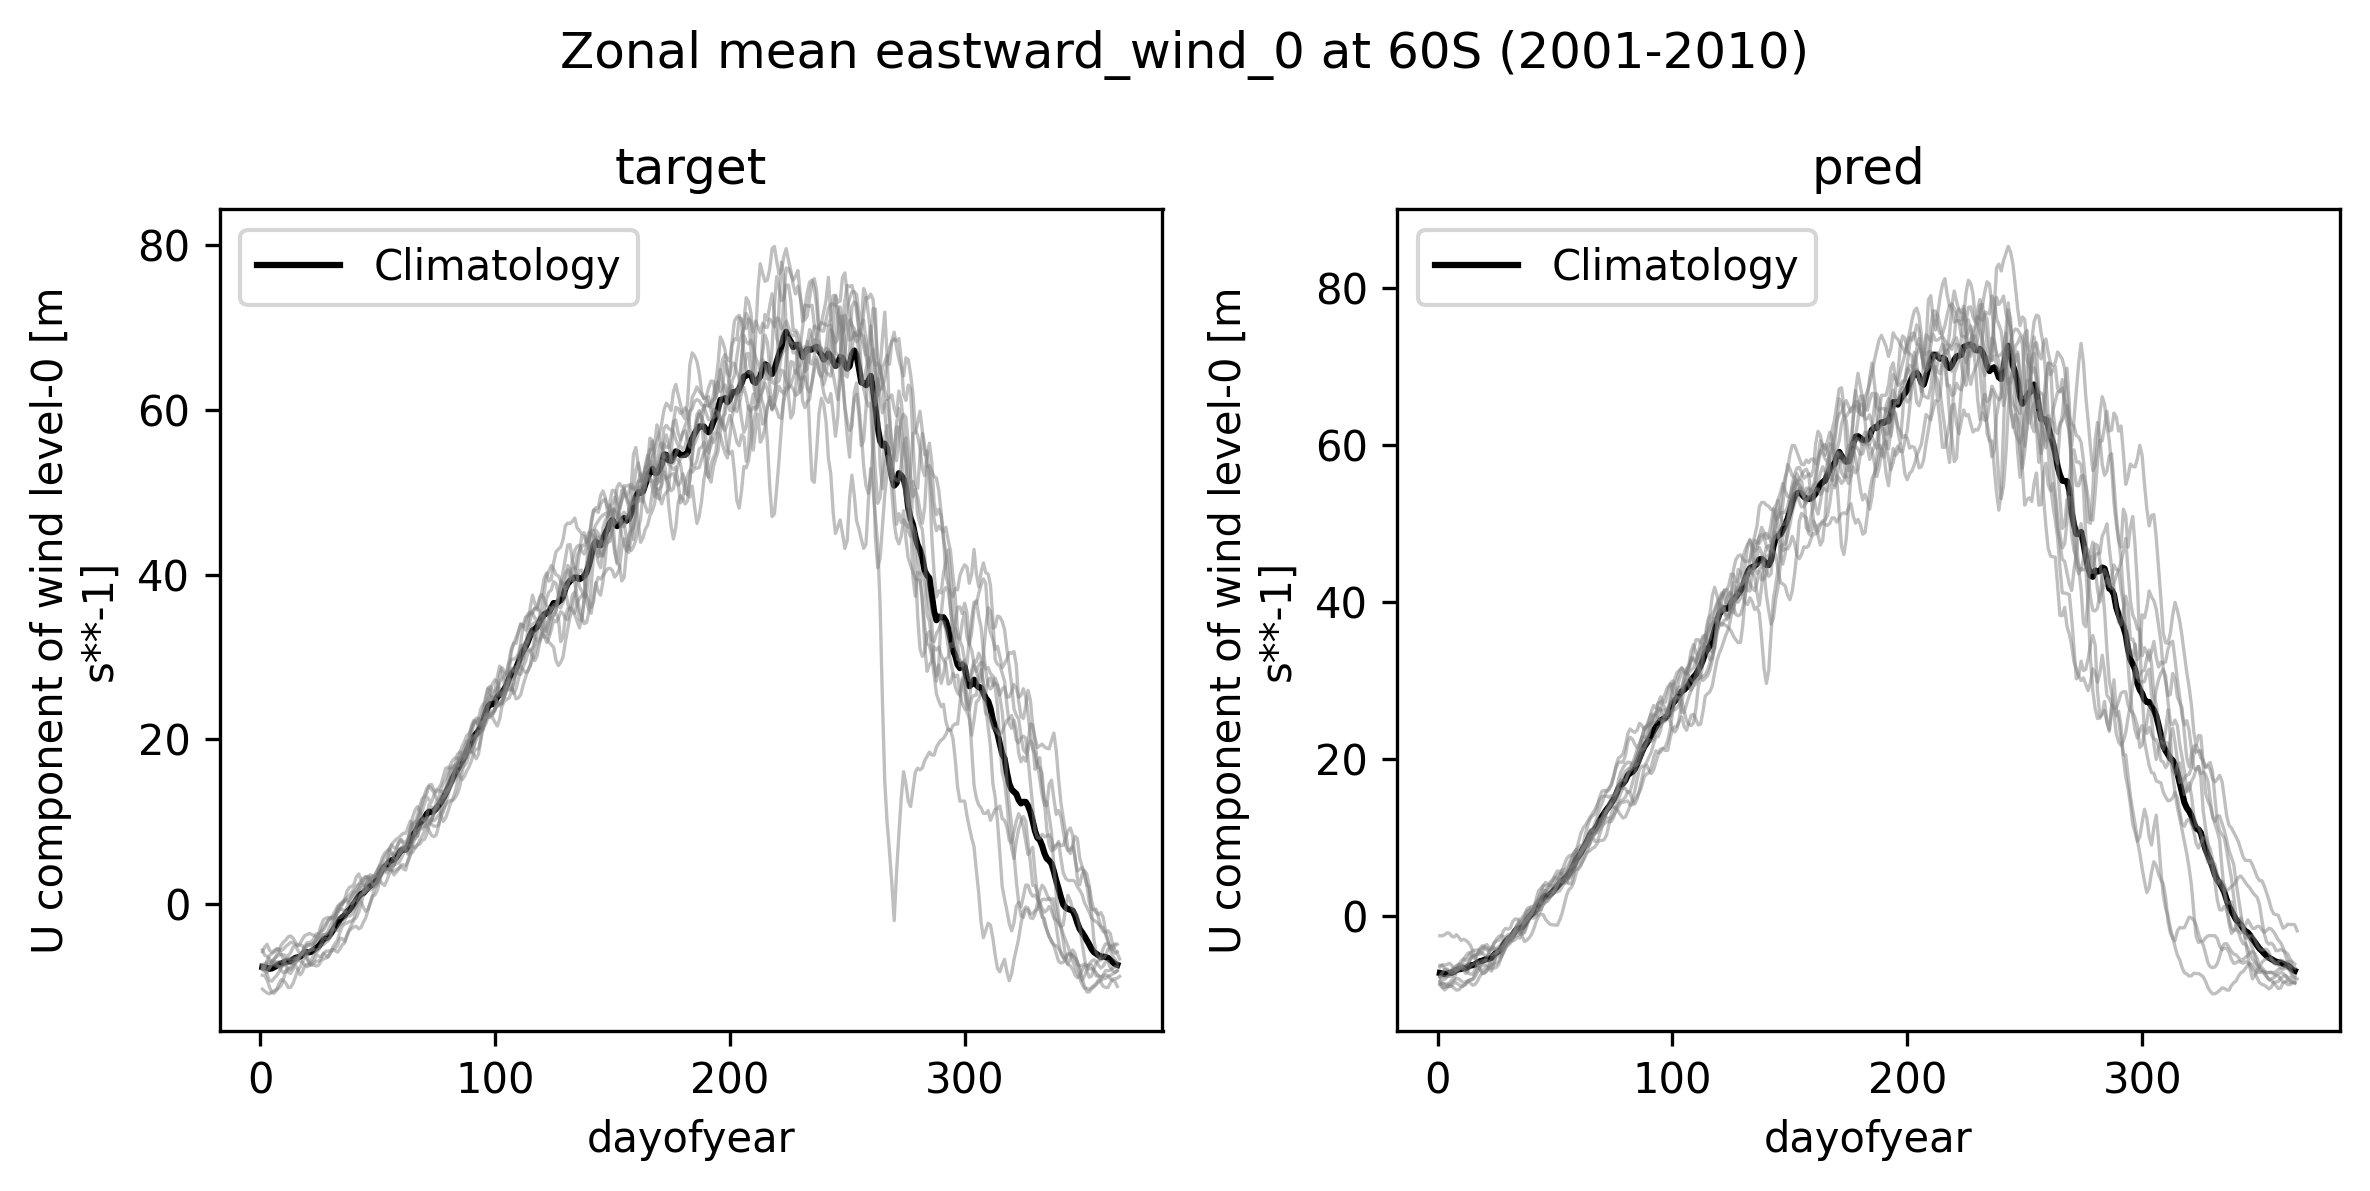

In [37]:
plot_combined_annual_cycle(ds_zm.eastward_wind_0, -60)